In [1]:
# import the required libraries
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(font_scale=1.5)

In [4]:
# read the final csv data 
data = pd.read_csv("../myInput/features.csv")
data.shape

(166, 8)

In [5]:
data.describe()

,surface,n_bhk,sa3,pool,sa1,gym,sa5,price
count,1.660000e+02,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,1.819161e-16,2.156627,0.054217,0.590361,0.042169,0.795181,0.066265,6.829157
std,1.003026e+00,0.617560,0.227130,0.493255,0.201582,0.404791,0.249497,2.575547
min,-2.373121e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.319000
25%,-5.399982e-01,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.800000
50%,-1.257601e-01,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,6.500000
75%,6.015373e-01,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,8.300000
max,3.050066e+00,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.900000


## Data prepration

In [6]:
data = data.sort_values("surface").reset_index(drop=True)

In [7]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data["price"]


In [8]:
# Random sate for data splitting
rs = 118
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=rs) 

In [9]:
# function for performing grid search
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split
    
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


    

In [10]:
# function to plot the residuals
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)                                                     
                                                          
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")


    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

## Ordinary Linear Regression

In [11]:
# define a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [12]:
# check for the r2 score on train and tets data
r2_score(y_train, lr.predict(X_train)),\
r2_score(y_test, lr.predict(X_test))

(0.7179944930356716, 0.697372366472731)

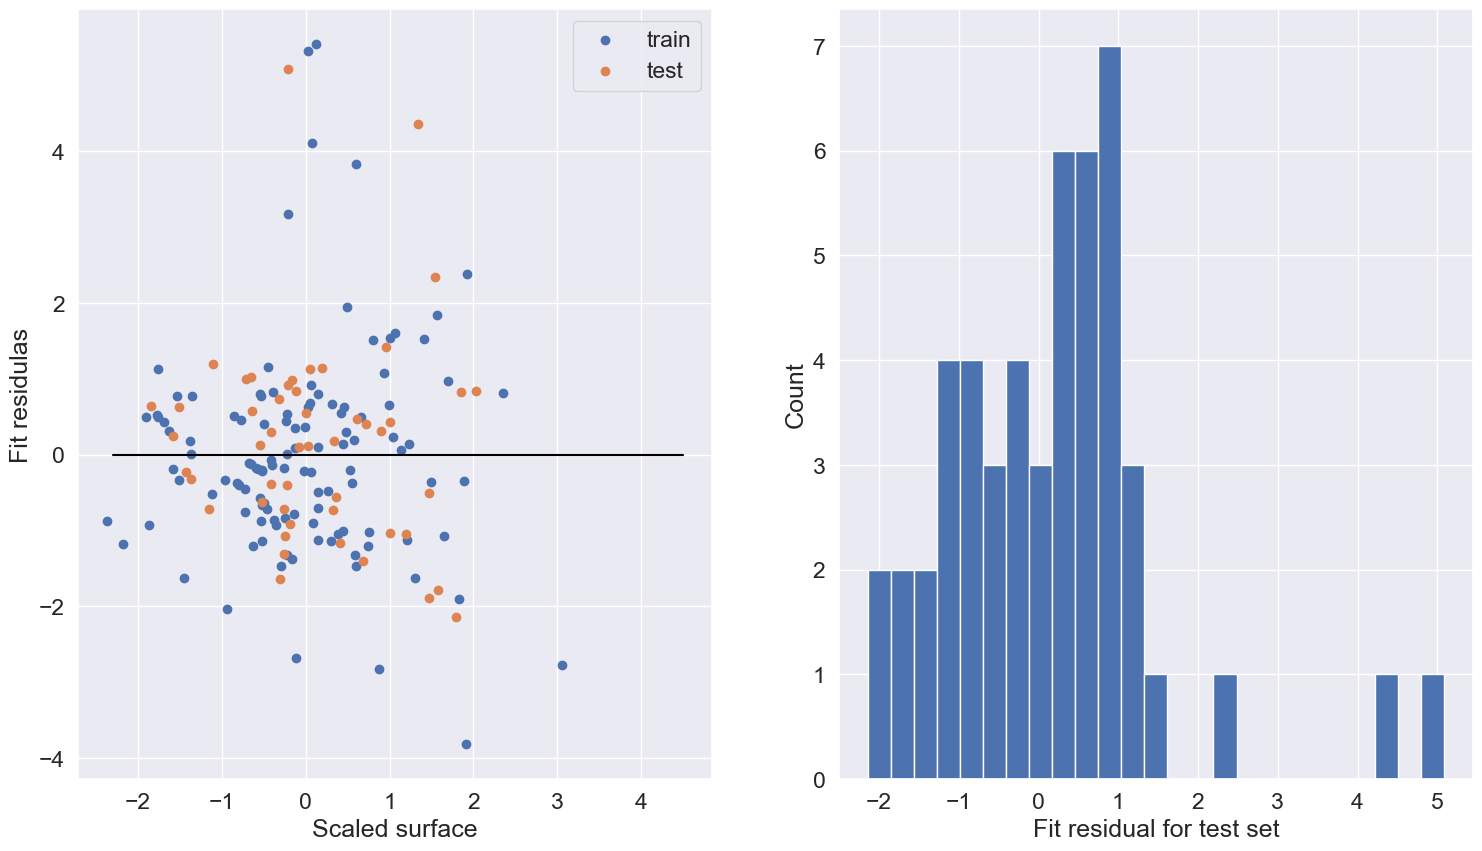

mean residuals: 0.17 
std: 1.34


In [13]:
# plot the residuals
plotResidue(lr, X, y, rs=rs)

## Ridge Regression

In [14]:
# define the parameters for ridge regression model and check for the grid search 
alphas = np.logspace(-3,3,100)
pg = {"alpha":alphas}
ridge = Ridge()
ridg_cv = gridSearchReport( ridge, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.8111308307896873}
Best CV score: 2.1797557660125113
MSE, R2 train: 1.9205105218795375 ,  0.7169491960005933
MSE, R2 test: 1.8308336448909919 ,  0.6970525071261484
Elapsed time: 28.4 s , 0.47 min


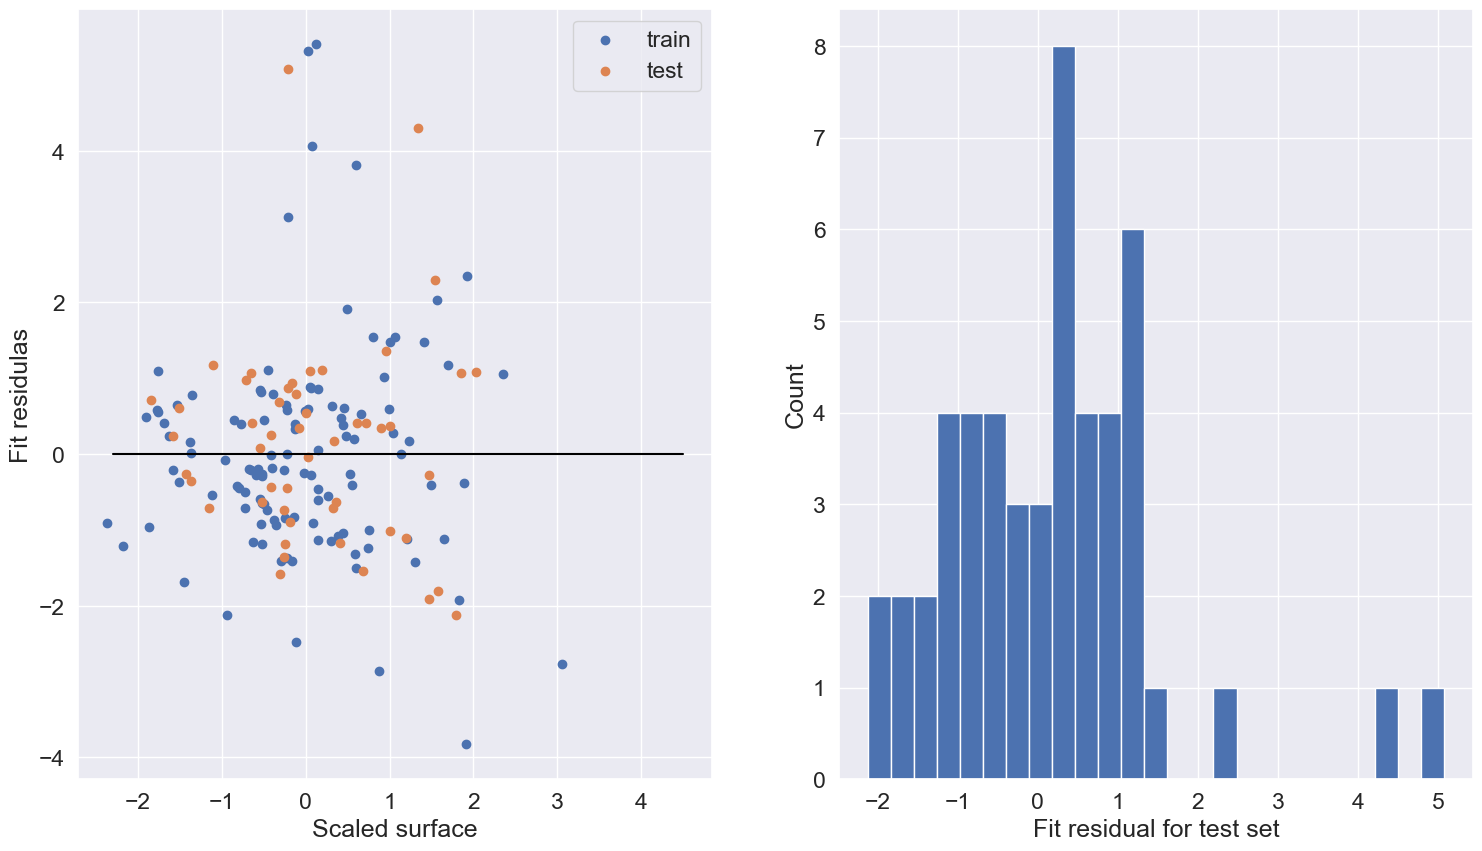

mean residuals: 0.16 
std: 1.34


In [15]:
# plot the residuals
plotResidue(ridg_cv, X, y, rs)

## Lasso Regression

In [16]:
# define the parameters and plot the lasso regression model
lasso = Lasso()
pg = {"alpha":alphas}
lasso_cv = gridSearchReport( lasso, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.0023101297000831605}
Best CV score: 2.1888206672742494
MSE, R2 train: 1.9139712311257784 ,  0.7179129769767193
MSE, R2 test: 1.8241624694882832 ,  0.6981563845146876
Elapsed time: 27.67 s , 0.46 min


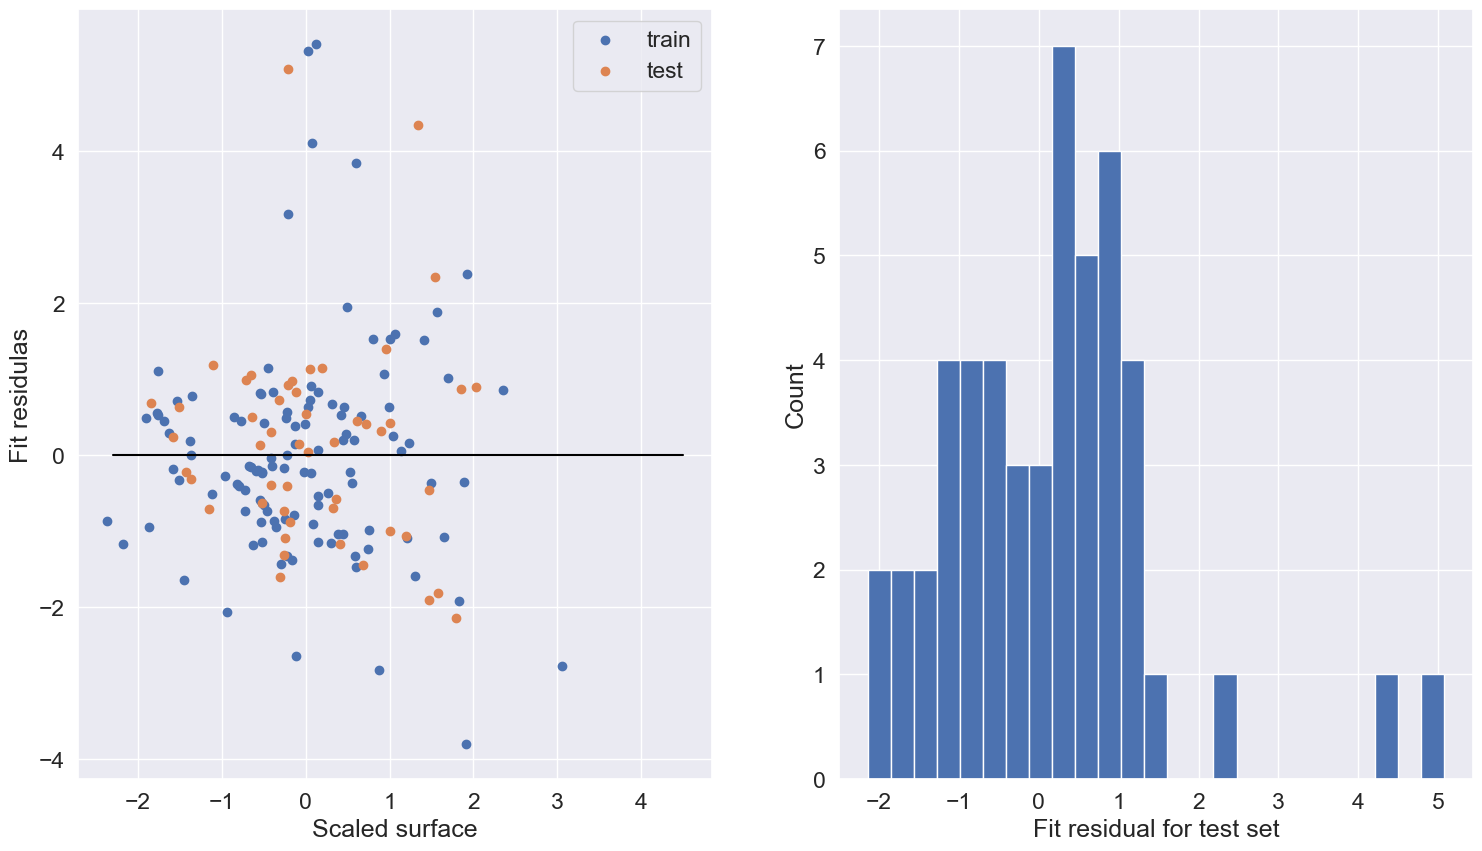

mean residuals: 0.16 
std: 1.34


In [17]:
# plot the residuals 
plotResidue(lasso_cv, X, y, rs=rs)

## Lasso and Ridge Combination

In [18]:
# define an elasticnet model 
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {"alpha":np.linspace(0.1,1,5), "l1_ratio":l1_ratio}
elastic_cv = gridSearchReport( elastic, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.07953760293858869}
Best CV score: 2.3159132984132276
MSE, R2 train: 2.1337646650086253 ,  0.6855191382210509
MSE, R2 test: 1.976361054501332 ,  0.6729721304032793
Elapsed time: 26.55 s , 0.44 min


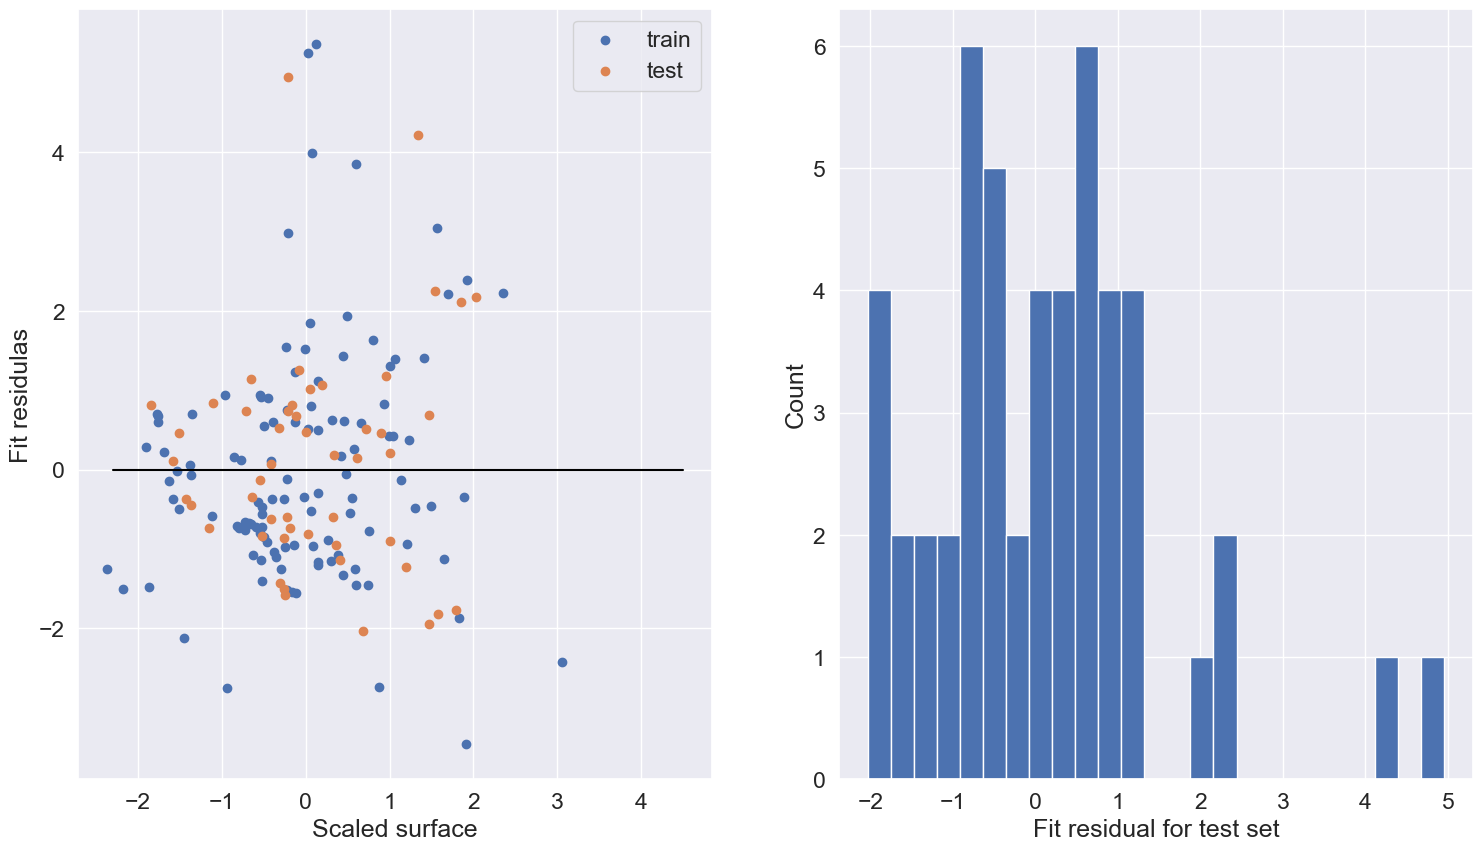

mean residuals: 0.13 
std: 1.4


In [19]:
# plot the residuals
plotResidue(elastic_cv, X, y, rs=rs)

## Random Forest Regressor

In [22]:
# define a random forest regression model 
rfr = RandomForestRegressor( random_state=10 )
pg = {"n_estimators":[10, 20, 30, 50],
         "criterion":["squared_error", "absolute_error", "poisson"],
         "max_depth":[2,3,4],
         "min_samples_split":range(2, 10),
         "min_samples_leaf":[2,3],
         "max_features":range(4, X_train.shape[1]+1) 
        }
rfr_cv = gridSearchReport( rfr, X, y, pg, cv=5, rs=rs )

Best parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}
Best CV score: 2.441015572168765
MSE, R2 train: 1.5888758256915232 ,  0.7658265472677186
MSE, R2 test: 1.78169666253846 ,  0.7051831888255076
Elapsed time: 298.82 s , 4.98 min


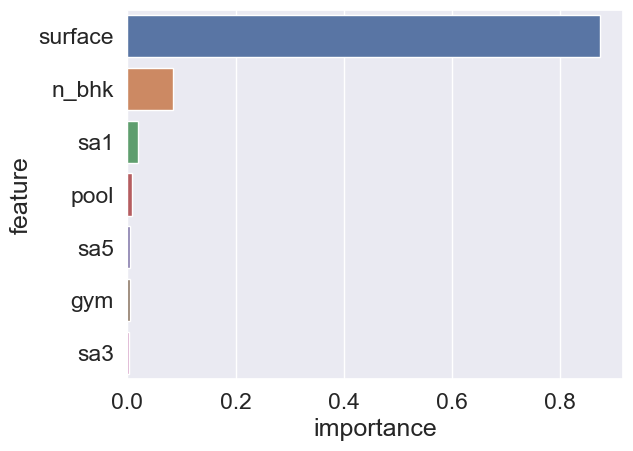

In [23]:
# find the best features 
rfr = rfr_cv.best_estimator_
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ["feature", "importance"]
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

sns.barplot( data=df_imp, x="importance", y="feature"  )
plt.show()

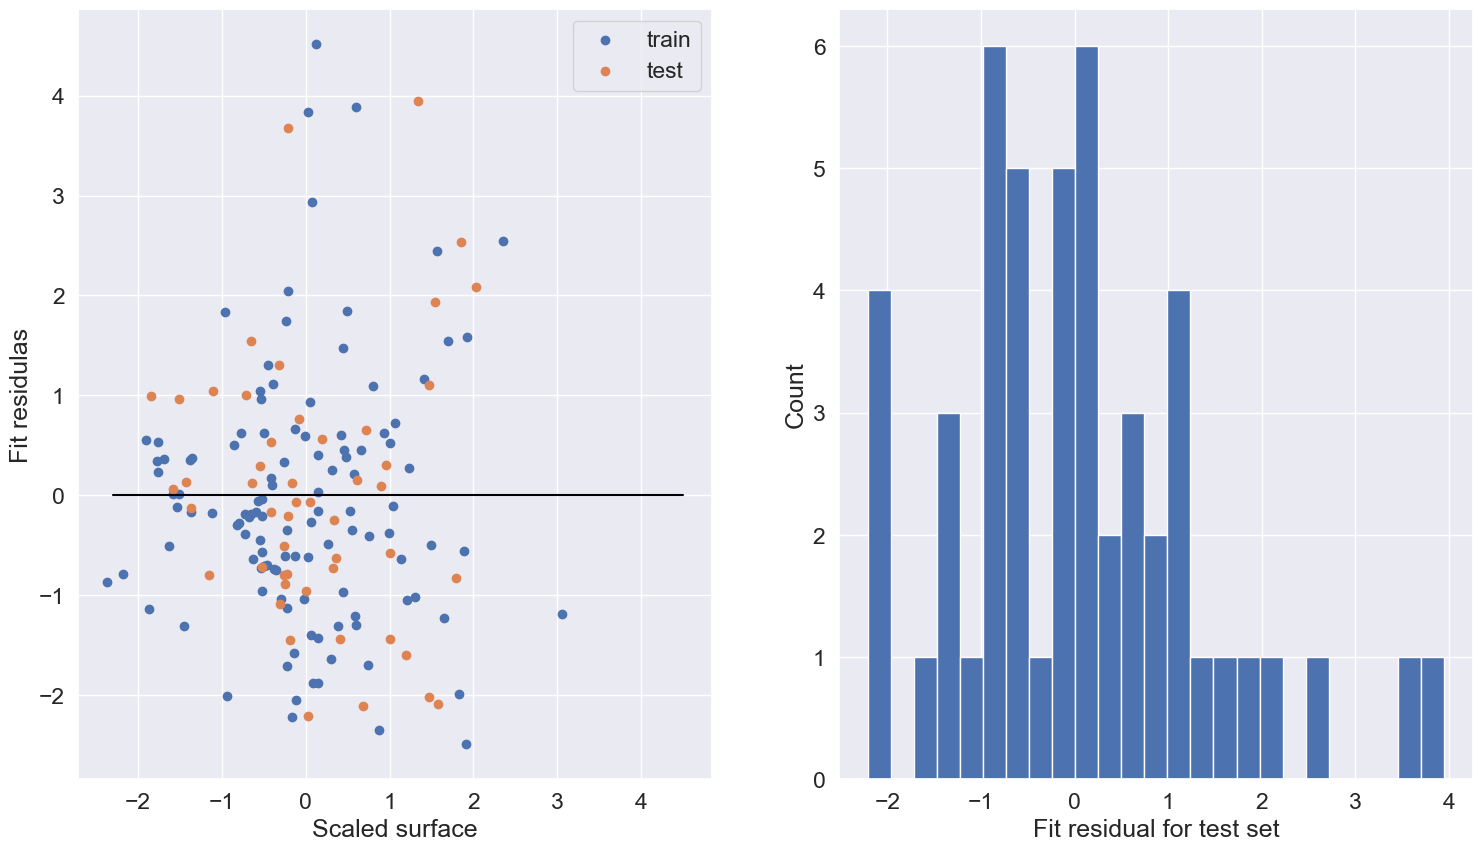

mean residuals: 0.03 
std: 1.33


In [24]:
# plot the residuals
plotResidue(rfr_cv, X, y, rs=rs)

## XGboost (extreme gradient boosting)

In [25]:
# define the parameters for XGBoost model
from scipy.stats import uniform
param_grid = {'max_depth':range(2,7),
      'gamma':uniform(loc=0.0, scale=3), # minimum of the loss function rduction to split a node
      'min_child_weight':range(3,6), # similar to min_samples_leaf
      'colsample_bytree':uniform(loc=0.1, scale=0.9), # similar to the max_features
      'subsample':uniform(loc=0.5, scale=0.5), # similar to bootstraping in RF
      'learning_rate':uniform(loc=0.01, scale=0.99)} # contriburion rate of each estimator

In [26]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(20)
n_iter=500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))

In [27]:
param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [28]:
# function to perform cross validation
from sklearn.model_selection import KFold

def cross_validate( est, Xn, yn, n_fold=10 ):
    """
    Cross validation for XGB fit.
    Params:
        est: xgb regressor
        Xn: numpy array (n_sample, n_feature)
            Training feature matrix
        yn: numpy array (n_sample,)
            Training target vector
        n_fold: int
            number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
        est.fit(Xn[train_index], yn[train_index], 
                    eval_set=[(Xn[train_index], yn[train_index]), 
                              (Xn[val_index], yn[val_index])],
                    eval_metric='rmse',
                    verbose=False, 
                    early_stopping_rounds=30)
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error/n_fold, mean_val_error/n_fold

In [29]:
%%time
xgbr = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000, verbosity=1 ) # XGBoost model

val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)  
    val_score.append(val_error)
    train_score.append(train_error)
    
    if counter%50 == 0 :
        print("iter =", counter, 
              "train_score=", train_score[counter], ", ", 
              "val_score=", val_score[counter])
    counter += 1
        

iter = 0 train_score= 1.9782595616602048 ,  val_score= 2.056798992853866
iter = 50 train_score= 2.1252674268122185 ,  val_score= 2.4977699971397915
iter = 100 train_score= 1.5802874721745088 ,  val_score= 2.5330030846562983
iter = 150 train_score= 1.938046049639875 ,  val_score= 2.740021690588951
iter = 200 train_score= 2.0138749434555794 ,  val_score= 2.3984100688582335
iter = 250 train_score= 1.893570080992535 ,  val_score= 2.3839784295136512
iter = 300 train_score= 1.5619444795159758 ,  val_score= 2.528091797123303
iter = 350 train_score= 1.8969756684947456 ,  val_score= 2.409324111886369
iter = 400 train_score= 1.7929371404081222 ,  val_score= 2.61033966808552
iter = 450 train_score= 1.8579839491632248 ,  val_score= 2.5969512717578755
CPU times: total: 19min 7s
Wall time: 5min 3s


In [30]:
df_grid = pd.DataFrame(param_list)
df_grid["train_score"] = train_score
df_grid["val_score"] = val_score
df_grid

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,1.978260,2.056799
1,0.722582,1.136043,0.523326,4,5,0.596925,2.059283,2.351530
2,0.345085,2.155818,0.785174,3,4,0.887622,1.787353,2.435074
3,0.132998,0.350081,0.753768,4,4,0.627403,1.911332,2.215278
4,0.871863,2.849337,0.566070,2,5,0.726722,2.073550,2.313408
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,1.837766,2.595115
496,0.211245,2.442034,0.178679,4,3,0.501152,1.901970,2.546550
497,0.772129,2.011557,0.063765,5,3,0.881116,1.665532,2.663527
498,0.206156,1.858437,0.288957,2,3,0.929107,1.941559,2.506680


In [31]:
df_grid_best = df_grid[ df_grid["val_score"]==min(val_score) ]
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
364,0.645513,2.171671,0.970234,2,4,0.581641,1.925115,1.947044


In [32]:
# best parameters
best_params = df_grid_best.iloc[0, :-2].to_dict()
best_params

{'colsample_bytree': 0.6455125076753658,
 'gamma': 2.171671409846681,
 'learning_rate': 0.9702339760420041,
 'max_depth': 2.0,
 'min_child_weight': 4.0,
 'subsample': 0.581640957266667}

In [40]:
best_params["max_depth"] = int(best_params["max_depth"])

In [41]:
xgbr.set_params(**best_params)
xgbr.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='rmse',
                verbose=True, 
                early_stopping_rounds=30)


[0]	validation_0-rmse:1.64599	validation_1-rmse:1.68636
[1]	validation_0-rmse:1.50461	validation_1-rmse:1.55422
[2]	validation_0-rmse:1.49982	validation_1-rmse:1.59164
[3]	validation_0-rmse:1.48066	validation_1-rmse:1.53871
[4]	validation_0-rmse:1.44322	validation_1-rmse:1.54938
[5]	validation_0-rmse:1.42875	validation_1-rmse:1.57134
[6]	validation_0-rmse:1.36428	validation_1-rmse:1.61463
[7]	validation_0-rmse:1.35712	validation_1-rmse:1.60565
[8]	validation_0-rmse:1.35049	validation_1-rmse:1.63047
[9]	validation_0-rmse:1.34599	validation_1-rmse:1.61487
[10]	validation_0-rmse:1.33605	validation_1-rmse:1.58971
[11]	validation_0-rmse:1.35414	validation_1-rmse:1.62273
[12]	validation_0-rmse:1.31856	validation_1-rmse:1.58058
[13]	validation_0-rmse:1.28227	validation_1-rmse:1.52107
[14]	validation_0-rmse:1.24924	validation_1-rmse:1.55408
[15]	validation_0-rmse:1.23461	validation_1-rmse:1.56598
[16]	validation_0-rmse:1.22824	validation_1-rmse:1.57459
[17]	validation_0-rmse:1.19677	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6657099102534205, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.4371922886203854,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.8054906321872517,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=4.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
xgbr.get_booster().attributes()

{'best_iteration': '23', 'best_score': '1.5747863853708424'}

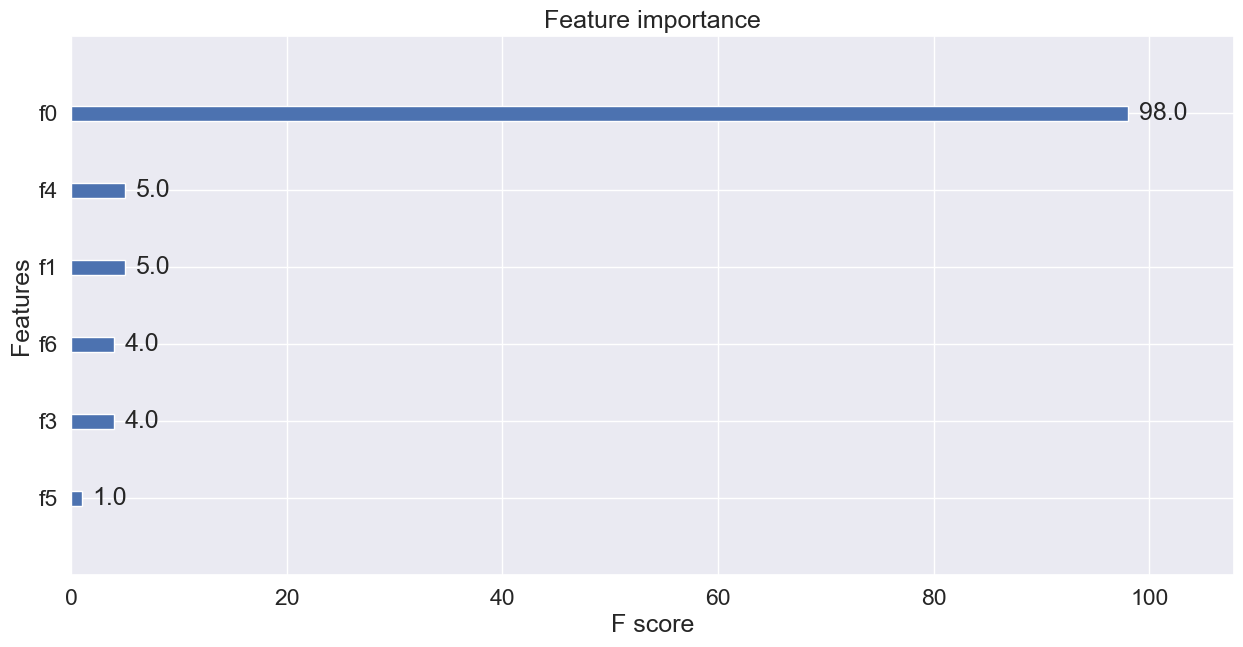

In [34]:
# plot the feature importance 
plt.rcParams["figure.figsize"] = (15,7)
xgb.plot_importance(xgbr)
plt.show()

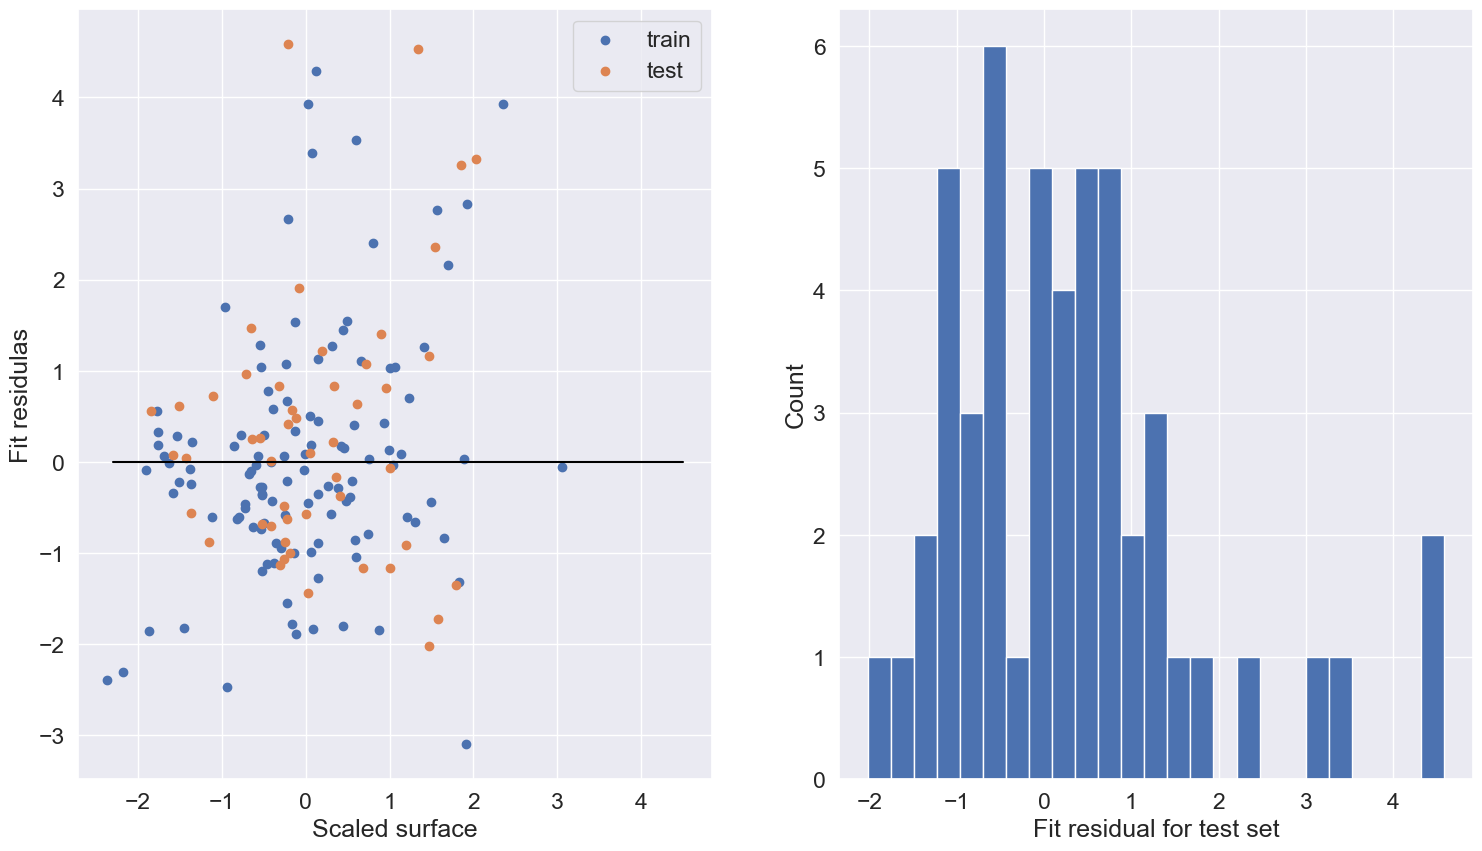

mean residuals: 0.31 
std: 1.44


In [35]:
#  plot the residuals
plotResidue(xgbr, X, y, rs=rs)

## K-Nearest Neighbours Regression

In [36]:
%%time
knn = KNeighborsRegressor() # KNN model
pg = {
    "n_neighbors": range(1,16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_cv = gridSearchReport( knn, X, y, pg, rs=rs )

Best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}
Best CV score: 2.56063320531316
MSE, R2 train: 1.9039378947924 ,  0.7193917212395624
MSE, R2 test: 1.8783680224489792 ,  0.6891870079604016
Elapsed time: 173.21 s , 2.89 min
CPU times: total: 11.8 s
Wall time: 2min 53s


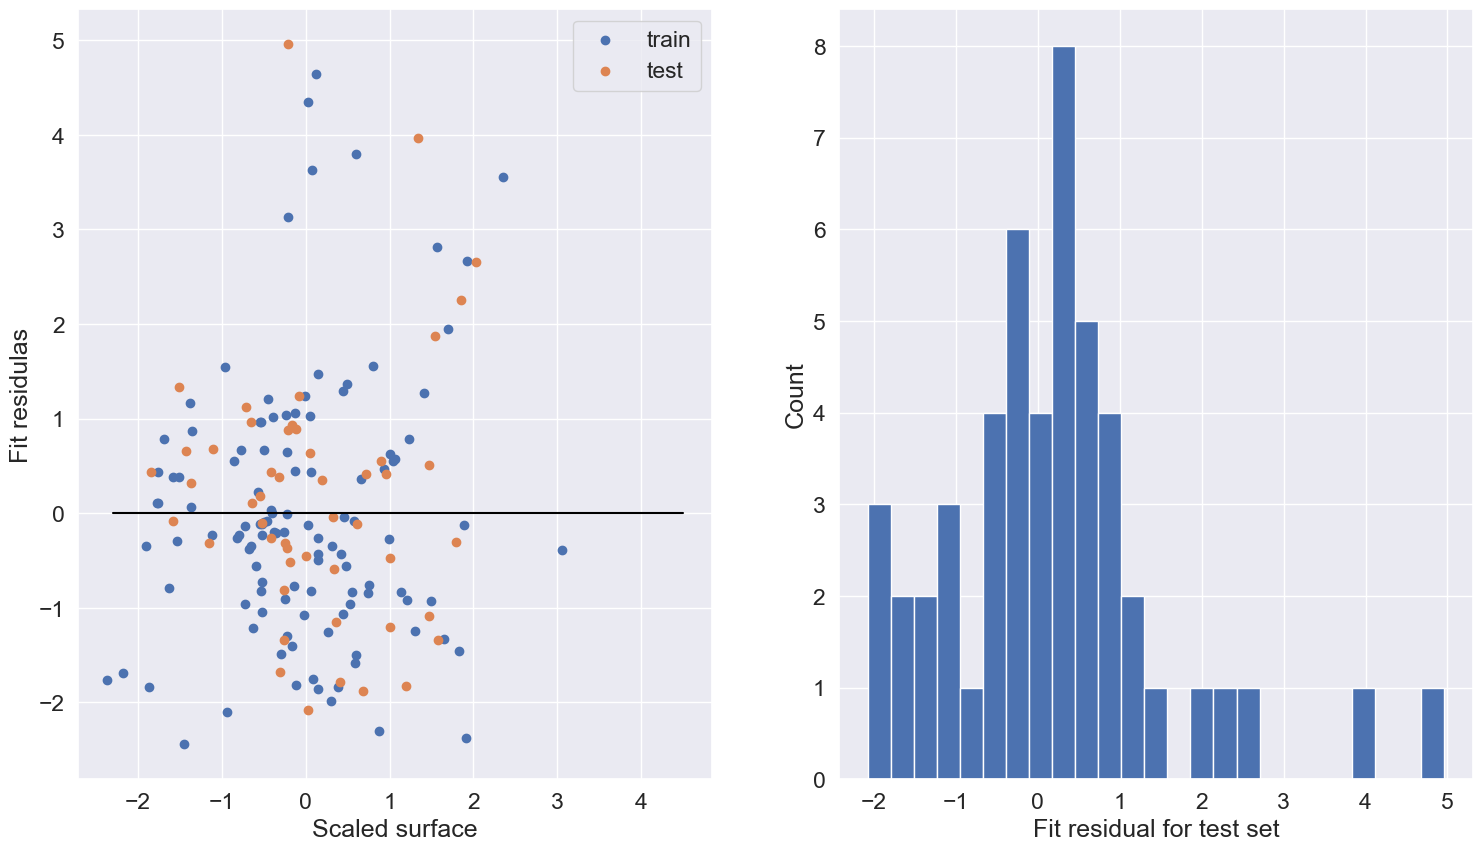

mean residuals: 0.18 
std: 1.36


In [37]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

In [38]:
from sklearn.model_selection import validation_curve
param_range = range(1,31)
knn_cv = KNeighborsRegressor()
train_scores, val_scores = validation_curve(knn_cv, 
                                             X_train, y_train, 
                                             param_name="n_neighbors",
                                             param_range=param_range,
                                             n_jobs=-1,
                                             scoring="neg_mean_squared_error", 
                                             cv=10
                                            )

In [39]:
train_scores.shape

(30, 10)

In [40]:
train_mean_score = -np.mean(train_scores, axis=1)
val_mean_score = -np.mean(val_scores, axis=1)

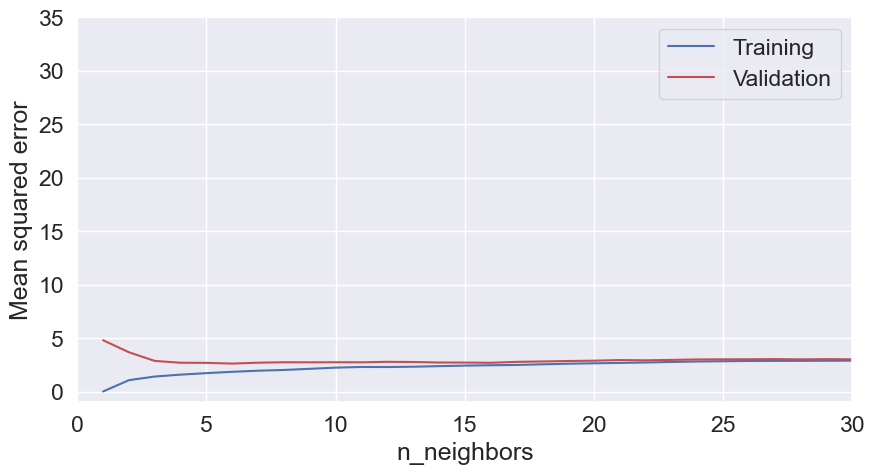

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, train_mean_score, color="b", label="Training" )
plt.plot( param_range, val_mean_score, color="r", label="Validation" )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(-1, 35)
plt.xlim(0, 30)
plt.ylabel( "Mean squared error" )
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


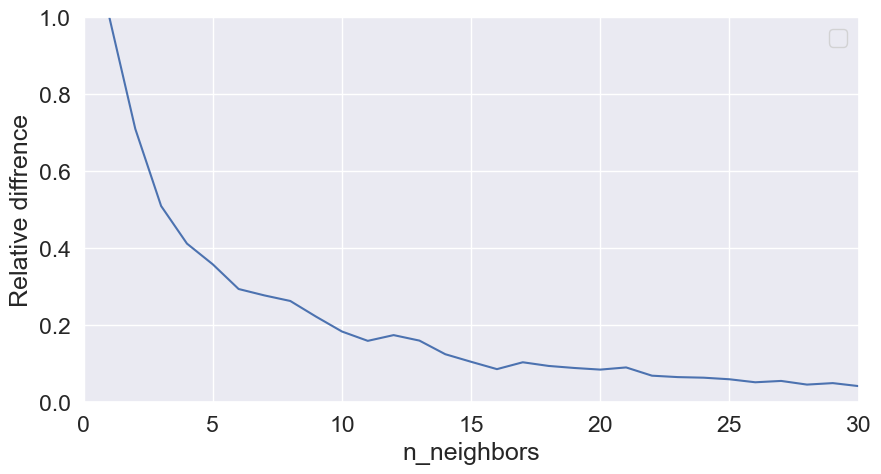

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, (val_mean_score-train_mean_score)/val_mean_score )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.ylabel( "Relative diffrence" )
plt.legend()
plt.show()

In [43]:
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")
knn_cv.fit( X_train, y_train )
y_pred_knn = knn_cv.predict(X_test)
print(r2_score(y_train, knn_cv.predict(X_train)) , r2_score(y_test, y_pred_knn))
mean_squared_error(y_train, knn_cv.predict(X_train)) , mean_squared_error(y_test, y_pred_knn) 

0.6240188779669189 0.6274520179859673


(2.551046281056033, 2.2514574170499997)

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_list = cross_val_score(knn_cv, X_train, y_train, 
                                 scoring="neg_mean_squared_error", cv=10)
score_val_knn = -np.mean(cross_val_list)
score_val_knn

2.8878132016496214

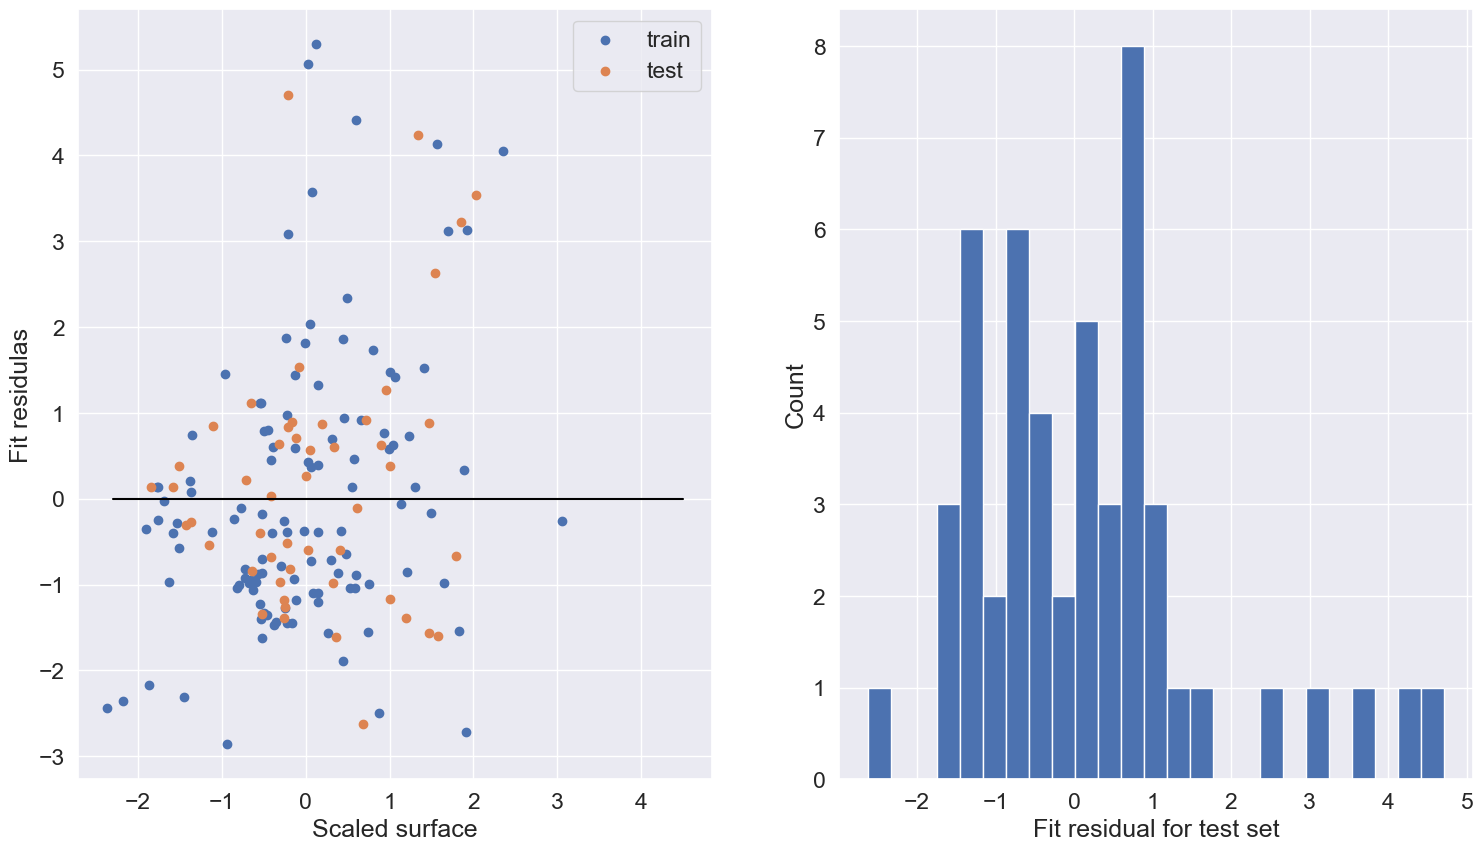

mean residuals: 0.17 
std: 1.49


In [45]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

## Suport Vector Regression

In [46]:
# SVR model
svr = SVR()
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'], # Kernel coefficient 
    "C": np.logspace(-3, 3, 10), # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10) # the decision boundary
}
svr_cv = gridSearchReport( svr, X, y, pg, cv=10, rs=rs )


Best parameters: {'C': 46.41588833612773, 'epsilon': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score: 2.0086518434347225
MSE, R2 train: 1.6019684900822697 ,  0.7638969097364082
MSE, R2 test: 1.552051848425097 ,  0.7431824471859072
Elapsed time: 73.82 s , 1.23 min


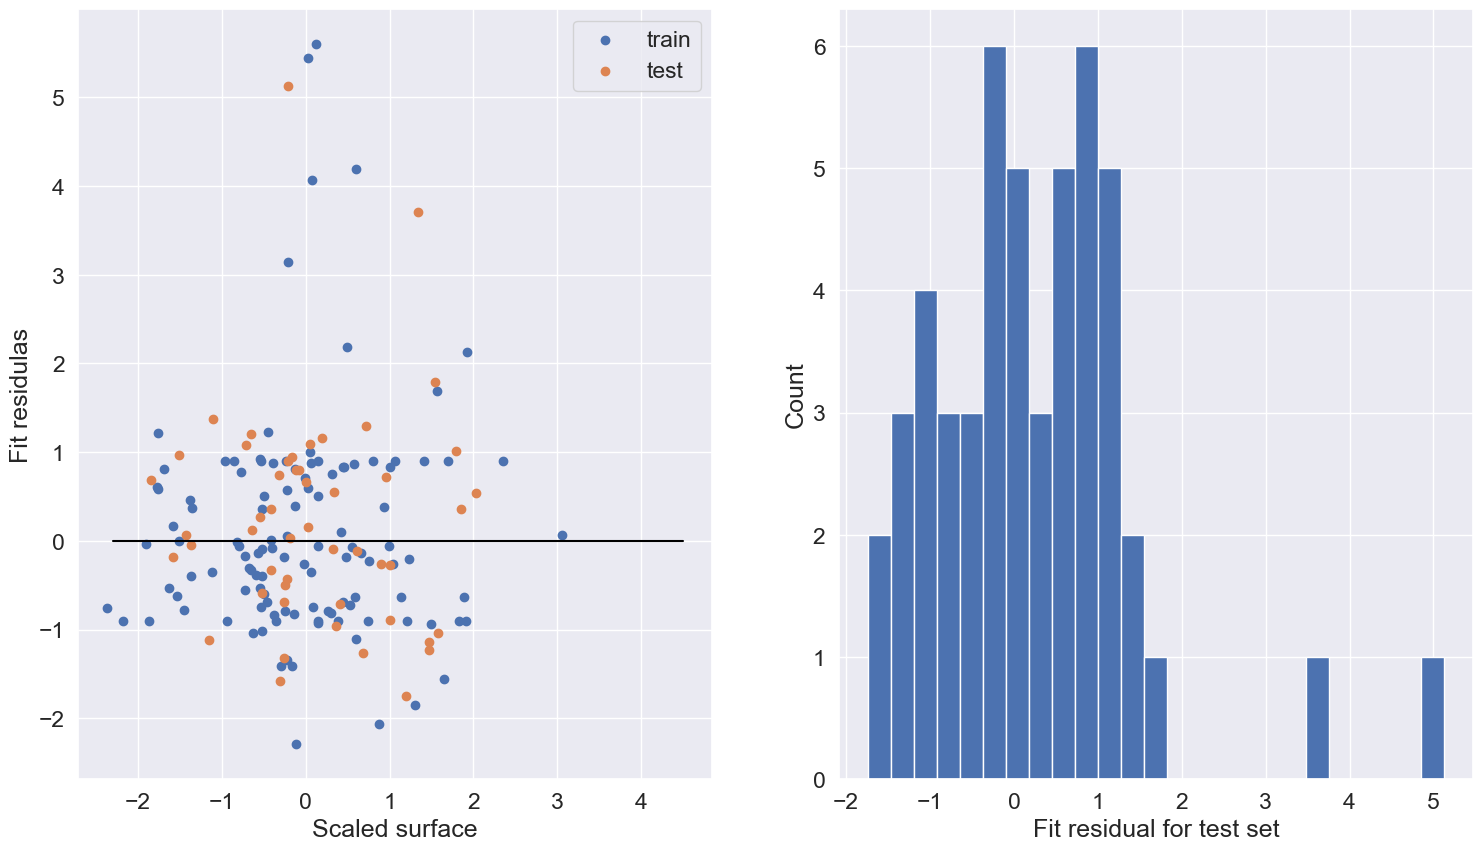

mean residuals: 0.24 
std: 1.22


In [47]:
# plot the residuals
plotResidue(svr_cv, X, y, rs=rs)

## Comparing the estimators

In [48]:
# fcuntions to make a comparision between all the models
def sortXy( X, y ):
    """
    Prepares the features to have the fit only for "surface" variable. 
    """ 
    df = X.copy()
    df["price"] = y
    df = df.sort_values("surface").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

#######################################
def get_scores( X, y, est_name, est ):
    """
    Computes the validation and tets scores. 
    Params:
        X: Pandas dataframe, feature data
        y: Pandas series, target
        est_name: str
            estromator name
        est: regressor
            the regression estimator
    Return:
        r2 for the test sample, mse for validation sample and the labels for plotting.
    """    
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name=="Linear Regression" :
        mse_cv = "--"
    elif est_name=="Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0],1)
    elif est_name=="K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn,1)
    else :
        mse_cv=round(abs(est.best_score_), 1)
    
    lbl = est_name+":  R2_test="+str(r2_test)+", MSE_cv="+str(mse_cv)
    
    return r2_test, mse_cv, lbl

    
#######################################
def plotLines( X, y, estimators, rs):
    """
    Plots the fitted curve for the given estimators to test data vs. "surface" variable.
    Params:
        X: Pandas dataframe 
            features 
        y: Pandas series 
            target
        estimators: list 
            list of regressors
        rs: int 
            random state
    """    
    X, y = sortXy( X, y )
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20,10))
    axe.scatter( X["surface"], y )
    i = 0
    for k, estimator  in estimators.items():
        r2_test, mse_cv, label = get_scores( X, y, k, estimator )
        axe.plot(X["surface"], estimator.predict(X), label=label, c=colors[i])
        i+=1
    axe.set_xlabel("Scaled surface")
    axe.set_ylabel("Price in millions")
    axe.legend()



In [49]:
estimators1 = {
              "Linear Regression": lr, 
              "Ridge Regression": ridg_cv, 
              "Lasso Regression": lasso_cv, 
              "Elastic Net": elastic_cv, 
}

estimators2 = {              
              "Random Forest Regression": rfr_cv, 
              "Extreme Gradient Boosting": xgbr, 
              "K-Nearest Neighbors Regression": knn_cv, 
              "Support Vector Regression": svr_cv
}



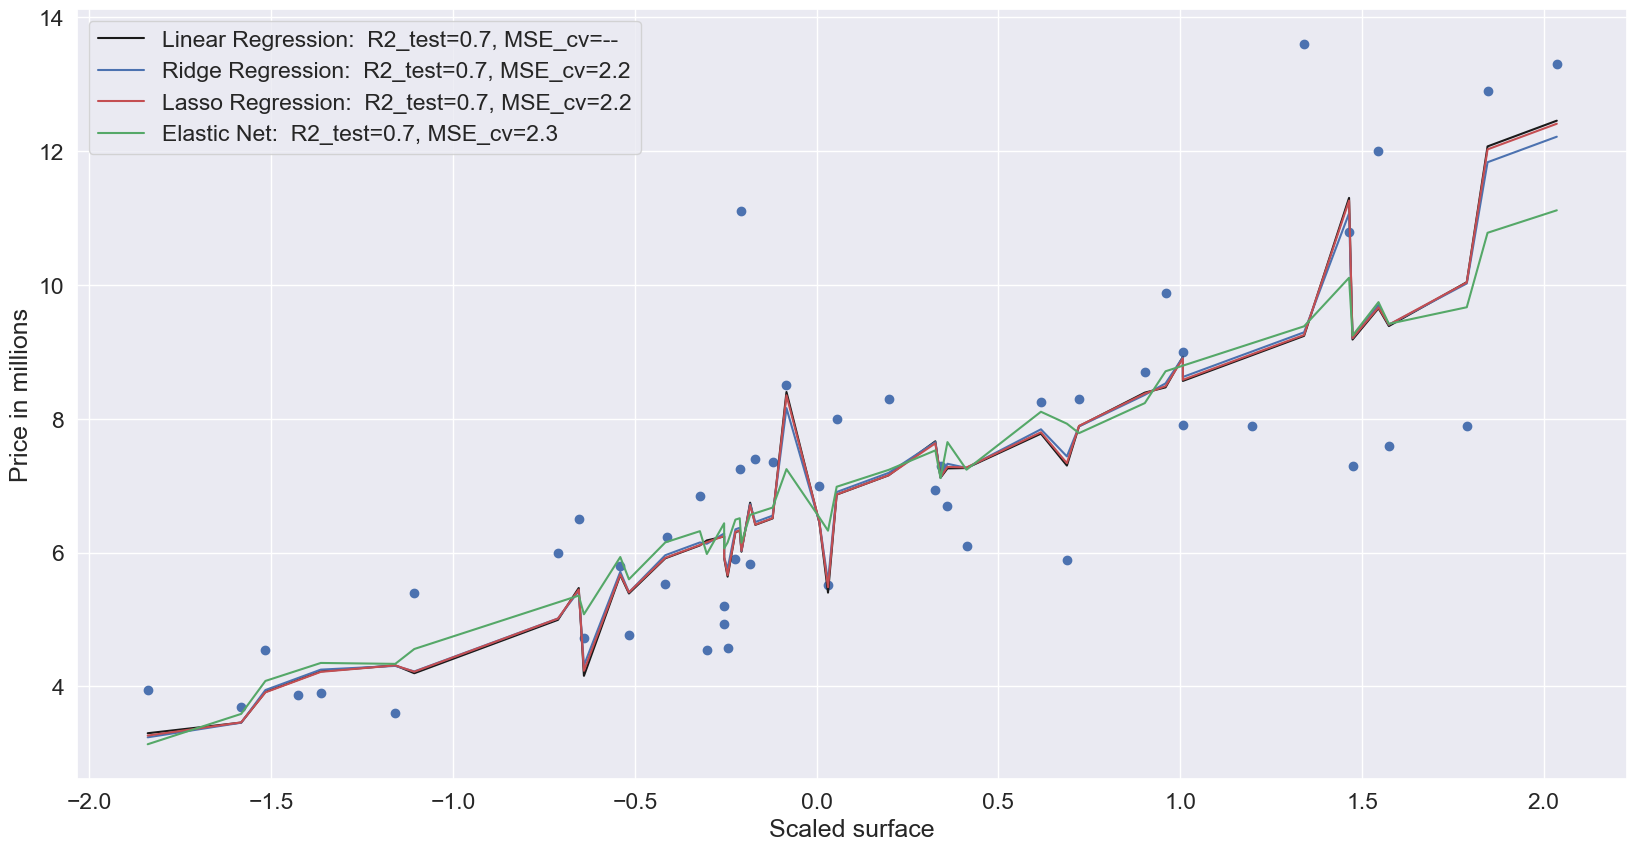

In [50]:
plotLines(X_test ,y_test, estimators1, rs=rs)

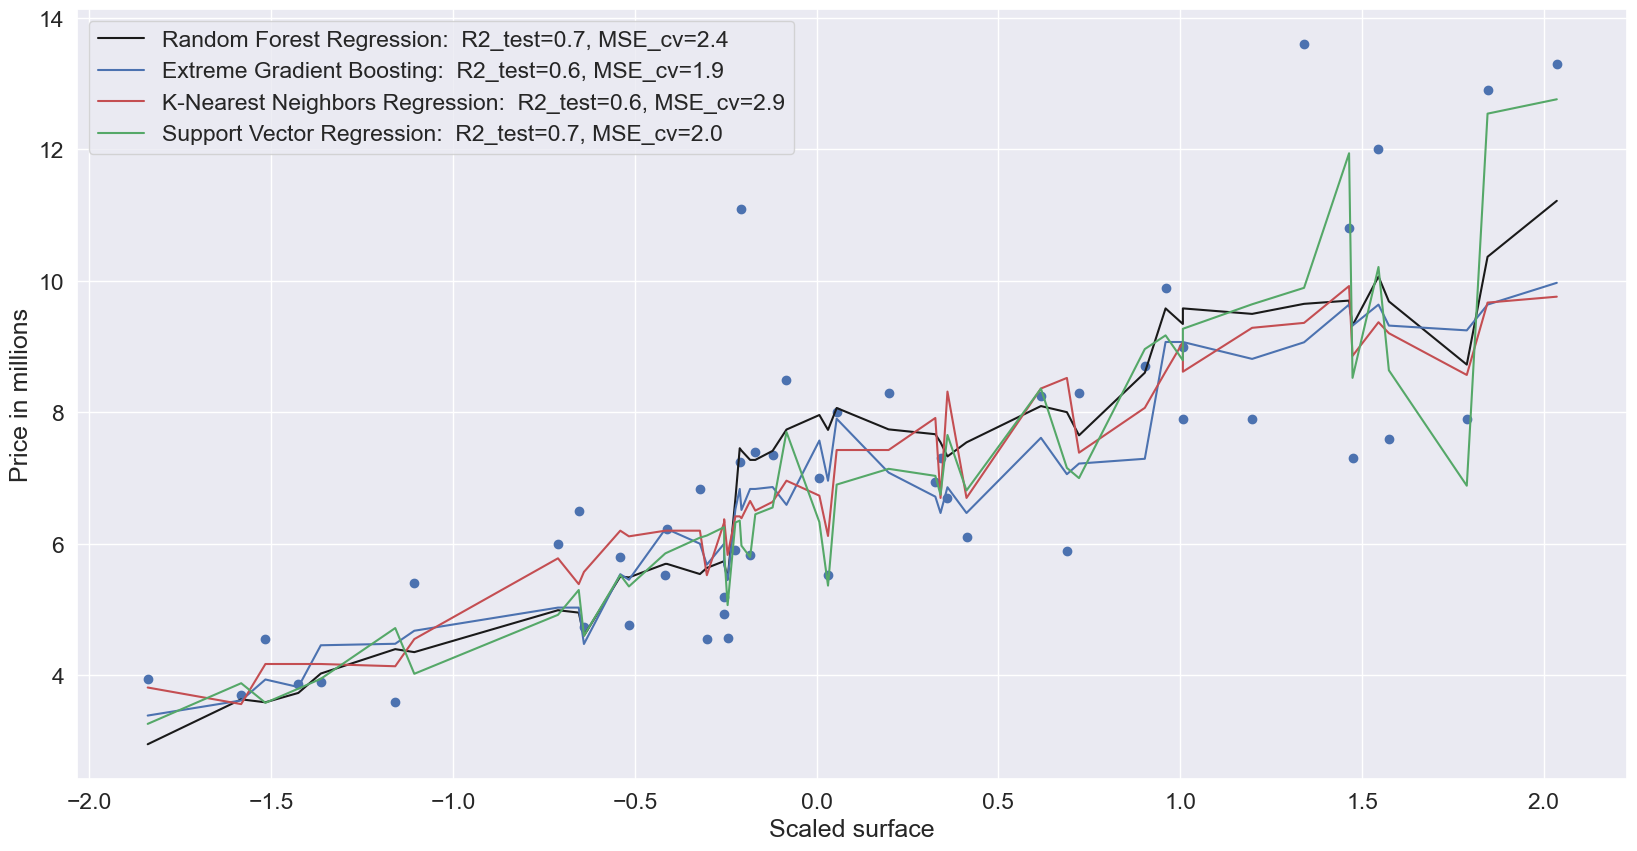

In [51]:
plotLines(X_test,y_test, estimators2, rs=rs)

# Conclusion

We have conclude that our best estimator at first is the  - 

Extreme Gradient boosting 

followd by Support Vector Regressor and then the Linear regression methods